In [1]:
import os
from pathlib import Path

import json

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from sklearn.cluster import KMeans, DBSCAN

import tensorflow as tf
from tensorflow import keras

from machine_learning.encoders import WaveNet_Encoder, CNN_Encoder, CNN_LSTM_Encoder, CNN_LSTM_SA_Encoder, LSTM_Encoder
from machine_learning.decoders import CNN_Decoder, WaveNet_Decoder, CNN_LSTM_Decoder, CNN_LSTM_SA_Decoder, LSTM_Decoder
from machine_learning.anomaly_detection import AutoEncoder, ED_Feedback

In [2]:
# Versuchsparameter
normal = 0
anomalies_percentage = 2
dataset = 'energy'
model_type = 'cnn-lstm-sa'

# ML-Parameter
batch_size = 32

# automatisch generiert
classes = [0,3] #list(range(num_anomaly+1))
percentage = anomalies_percentage/100
model_str = f'{dataset}-c{"".join(str(c)+"-" for c in classes)}p{anomalies_percentage}.hdf5'

model_dict = {
    'cnn': (CNN_Encoder, CNN_Decoder),
    'cnn-opt': (CNN_Encoder, CNN_Decoder),
    'cnn-vae': (CNN_Encoder, CNN_Decoder),
    'cnn-mec': (CNN_Encoder, CNN_Decoder),
    'wavenet': (WaveNet_Encoder, WaveNet_Decoder),
    'wavenet-mec': (WaveNet_Encoder, WaveNet_Decoder),
    'lstm': (LSTM_Encoder, LSTM_Decoder),
    'cnn-lstm': (CNN_LSTM_Encoder, CNN_LSTM_Decoder),
    'cnn-lstm-sa': (CNN_LSTM_SA_Encoder, CNN_LSTM_SA_Decoder),
}

# get the working directory of the ipykernel
working_dir = os.getcwd()

# define subdirectories
data_path = os.path.join(working_dir, "data")
dataset_path = os.path.join(data_path, dataset)
trainingset_path = os.path.join(dataset_path, "train")
testset_path = os.path.join(dataset_path, "test")

models_path = os.path.join(working_dir, "saved_models")
output_path = os.path.join(models_path, model_type)
Path(output_path).mkdir(parents=True, exist_ok=True)

print(model_str)
print(trainingset_path)
print(output_path)

energy-c0-3-p2.hdf5
/Users/david/repos/deep-anomaly-detection/data/energy/train
/Users/david/repos/deep-anomaly-detection/saved_models/cnn-lstm-sa


In [3]:
def aursad(dataset='train', classes=classes):

    path = None
    if dataset.lower() == 'train':
        path = trainingset_path
    elif dataset.lower() == 'test':
        path = testset_path
    else:
        raise ValueError("Invalid dataset specified")
    
    x = np.load(os.path.join(path, "x.npy"))
    y = np.load(os.path.join(path, "y.npy"))
    
    # extract the relevant classes only
    mask = [i in classes for i in y]
    x = x[mask,:,:]
    y = y[mask]
    
    return x, y

def unsupervised(percentage=percentage, batch_size=batch_size):
    
    x,y = aursad()
        
    num_normal_samples = np.sum(y == normal)
    num_anomalies = int(num_normal_samples / (1-percentage) * percentage)

    # extracts the first anomalous occurencies, until the desired percentage is achieved
    anomaly_idx = y != normal
    cum_anomaly_idx = np.cumsum(anomaly_idx)
    anomaly_mask = cum_anomaly_idx <= num_anomalies

    mask = np.logical_or(y == normal, anomaly_mask)

    x = x[mask,::]
    y = y[mask]
    
    total = x.shape[0]
    n = (total // batch_size) * batch_size
    
    x = x[:n,:,:]
    y = y[:n]
       
    return x, y

def semi_supervised(batch_size=batch_size):
    
    return unsupervised(percentage=0, batch_size=batch_size)

def supervised(dataset = "train", batch_size = batch_size):
    
    x,y = aursad(dataset=dataset)
    
    total = x.shape[0]
    n = (total // batch_size) * batch_size
    
    x = x[:n,:,:]
    y = y[:n]
       
    return x, y

def holdout_validation(x, y, percentage=0.8, batch_size=batch_size):

    split_idx = int((len(y) * percentage // batch_size) * batch_size)

    x_train = x[:split_idx,::]
    y_train = y[:split_idx]
    x_val = x[split_idx:,::]
    y_val = y[split_idx:]

    return (x_train, y_train), (x_val, y_val)


x_peek, _= aursad()
sequence_length = x_peek.shape[1]
num_features = x_peek.shape[2]

print(f'Sequence length = {sequence_length}')
print(f'Number of features = {num_features}')

print(len(unsupervised(percentage=percentage)[0]))

Sequence length = 480
Number of features = 4
1120


In [4]:
latent_dim = 6

# load the training data
train_x, _ = unsupervised()

# build the model
vaeAD = AutoEncoder(encoder=model_dict[model_type][0], decoder=model_dict[model_type][1],
                  input_shape=train_x.shape, latent_dim=latent_dim, is_variational=False)

vae = vaeAD.get_model()
vae.summary()

encoder = vaeAD.get_encoder()
encoder.summary()

decoder = vaeAD.get_decoder()
decoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
inputs.shape=(None, 80, 16)
scores.shape=(None, 80, 80)
context.shape=(None, 80, 16)
inputs.shape=(None, 80, 16)
scores.shape=(None, 80, 80)
context.shape=(None, 80, 16)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 4)]          0         
_________________

In [5]:
# train the VAE on MNIST digits
x, y = unsupervised()
(x_train, _), (x_val, _) = holdout_validation(x, y)
print(x_train.shape)

callbacks = [
        keras.callbacks.ModelCheckpoint(
        monitor = 'val_loss',
        filepath = os.path.join(output_path, model_str), 
        save_weights_only = False,
        save_best_only = True),

        keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
        ]

history = None
training = False

if training:
    history = vae.fit(x_train, x_train, epochs=360, shuffle=True, batch_size=batch_size,
        callbacks=callbacks, validation_data=(x_val, x_val))
    with open(os.path.join(output_path, "history.json"), 'w') as file:
            json.dump(history.history, file)
else:
    vae.load_weights(os.path.join(output_path, model_str))

(896, 480, 4)


In [6]:
def plot_history(history, metrics):

    for metric in metrics:
        data = history.history[metric]
        plt.plot(data)
    plt.legend(metrics)

unsupervised_metrics = ["loss", "val_loss"]
#plot_history(history, unsupervised_metrics)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-10-02 21:13:44.371806: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-02 21:13:44.372110: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


inputs.shape=(32, 80, 16)
scores.shape=(32, 80, 80)
context.shape=(32, 80, 16)


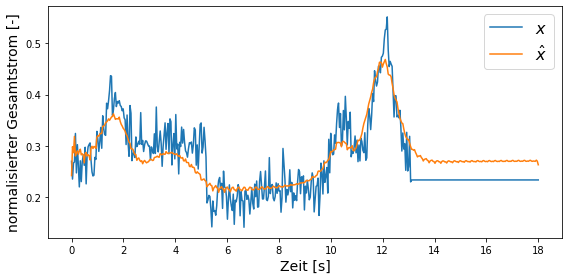

In [7]:
def plot_reconstruction(sample=0, feature=0):

    x = x_train[sample, :, feature]
    x_hat = vae.predict(x_train)[sample, :, feature]

    fig, ax = plt.subplots(figsize=(8,4))
    time = np.linspace(0, 18, num=x.shape[0])
    time_ticks = np.arange(0, 20, step=2)

    ax.plot(time, x, label=r'$x$')
    ax.plot(time, x_hat, label=r'$\hat{x}$')

    ax.set_xticks(time_ticks)
    ax.set_xlabel("Zeit [s]", fontsize=14)
    ax.set_ylabel("normalisierter Gesamtstrom [-]", fontsize=14)

    ax.legend(fontsize=16)

    fig.tight_layout()

plot_reconstruction(sample=3, feature=1)

In [8]:
#keras.utils.plot_model(vae, show_shapes = True)

### Aktives Lernen - Feedback für das Gesamtmodell
Im unüberwachten Szenario ist der Verlust unverändert, im überwachten Szenario wird auf den Verlus der BinaryCrossEntropyLoss des Klassifikator aufaddiert

In [9]:
activeAD = ED_Feedback(vaeAD)
#keras.utils.plot_model(activeAD.get_supervised(), show_shapes=True)

In [10]:
#keras.utils.plot_model(vae_al, show_shapes = True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
inputs.shape=(32, 80, 16)
scores.shape=(32, 80, 80)
context.shape=(32, 80, 16)
scores:  (80, 80)
max: 0.012556693516671658, min: 0.012447268702089787


/var/folders/ht/74j_l0hj2lzg0r9j2xgjmd3r0000gn/T/ipykernel_40895/4280066207.py:54: UserWarning: Use the colorbar set_ticks() method instead.
  ax0.set_yticks(np.linspace(np.min(scores), np.max(scores), 2))
/var/folders/ht/74j_l0hj2lzg0r9j2xgjmd3r0000gn/T/ipykernel_40895/4280066207.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(['niedrig', '', 'mittel', '', 'hoch'])


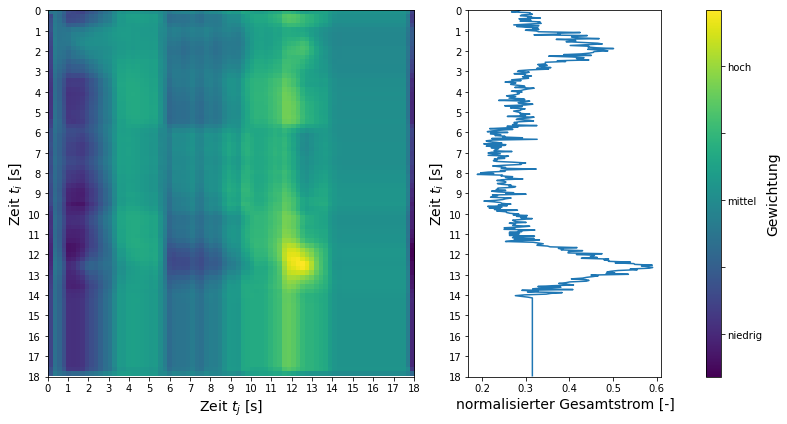

In [94]:
def attention_visualizer():
    
    #(orig, _), (_, _) = aursad()
    
    attention_vis = vaeAD.encoderWrapper.attention_model()
    
    scores = attention_vis.predict(x_train[:batch_size,:,:])[0,:,:]
    #scores = np.log(scores)
    print("scores: ",scores.shape)
    print(f'max: {np.max(scores)}, min: {np.min(scores)}')

    #plt.imshow(scores, cmap='hot', interpolation='nearest')
    #plt.show()

    #print(scores.shape)
    
    n = scores.shape[0]
    n = n//10
    
    #print(np.sum(scores, axis=1))
    
    fig, (ax1, ax2, ax0) = plt.subplots(1,3,gridspec_kw={'width_ratios': [8,4,0.3]}, figsize=(11,6))
    im = ax1.imshow(scores)
    
    ax1.set_xticks(np.arange(19)*80/18-0.5)
    ax1.set_xticklabels(np.arange(19))
    ax1.set_xlabel(r'Zeit $t_j$ [s]', fontsize=14)
    ax1.set_yticks(np.arange(19)*80/18-0.5)
    ax1.set_yticklabels(np.arange(19))
    ax1.set_ylabel(r'Zeit $t_i$ [s]', fontsize=14)

    ## Loop over data dimensions and create text annotations.
    #for i in range(10):
    #    for j in range(10):
    #        text = ax1.text(j*n, i*n, np.round(scores[i*n, j*n],2), ha="center", va="center", color="w")

    # ax1.set_title("Attention heat map")

    clb = fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=np.min(scores), vmax=np.max(scores))), orientation='vertical', cax=ax0)
    
    timeseries = x_train[0,:,1]

    ax2.plot(timeseries,-np.arange(0,len(timeseries)))
    ax2.set_ylim(-len(x_train[0,:,0]),0)

    ax2.set_xlabel('normalisierter Gesamtstrom [-]', fontsize=14)

    ax2.set_yticks(-np.arange(19)*480/18)
    ax2.set_yticklabels(np.arange(19))
    ax2.set_ylabel(r'Zeit $t_i$ [s]', fontsize=14)

    #ax4.axis('off')
    ax0.set_ylabel('Gewichtung', fontsize=14)
    ax0.set_yticks(np.linspace(np.min(scores), np.max(scores), 2))
    ax0.set_yticklabels(['niedrig', '', 'mittel', '', 'hoch'])
    
    fig.tight_layout()
    fig.savefig('figures/attention_map.pdf', bbox_inches='tight')
   
attention_visualizer()

In [ ]:
#assert False

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def color_from_label(labels):
    l2c = {0:'tab:blue',
           1:'tab:orange',
           2:'tab:green',
           3:'tab:red',
           4:'tab:purple',
          }
    return [l2c[label] for label in labels]


def latent_space_pca(dim=2, dataset='train'):

    x, y = supervised(dataset=dataset)
    pca = PCA(n_components=dim)

    z = encoder.predict(x)
    z_pca = pca.fit_transform(z)

    if dim==3:
        from mpl_toolkits import mplot3d
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
        ax.scatter3D(z_pca[:,0], z_pca[:,1], z_pca[:,2], c=color_from_label(y), alpha=0.5)

    plt.figure(figsize=(15,15))
    plt.scatter(z_pca[:,0], z_pca[:,1], c=color_from_label(y))

def visualize_latent_space(show_size=False, dataset='test'):

    x, y = supervised(dataset=dataset)

    z = encoder.predict(x)
    z_1 = z[:,0]
    z_2 = z[:,1]

    plt.figure(figsize=(15,15))
    plt.scatter(z_1, z_2, c=color_from_label(y))

def export_latent_space(dataset='train'):
    x, y = supervised(dataset=dataset)

    z = encoder.predict(x)
    np.savetxt('dumps/latent_vae_z.csv', z)
    np.savetxt('dumps/latent_vae_y.csv', y)

#visualize_latent_space()
latent_space_pca(dim=2)
#export_latent_space()

In [ ]:
def mahalanobis_anomaly_score_series(x_true, x_pred):
    
    a = np.zeros((x_true.shape[0], x_true.shape[1]))
    for t in range(x_true.shape[1]):
        
        xt_true = x_true[:,t,:]
        xt_pred = x_pred[:,t,:]
        
        error = np.abs(xt_true-xt_pred)
    
        mu = np.mean(error, axis=0)
        #print(mu.shape)
        
        cov = np.cov(error, rowvar=False)
        if cov.shape == ():
            inv_cov = 1/cov
        else:
            inv_cov = np.linalg.inv(cov)
        #print(cov.shape)
        
        for s in range(x_true.shape[0]):
            e = error[s,:]

            if inv_cov.shape == ():
                a[s,t] = inv_cov * np.matmul((e-mu).T,(e-mu))
            else:
                a[s,t] = np.matmul(np.matmul((e-mu).T, inv_cov),(e-mu))
        
    return a

def show_anomaly_score(sample=0, label=0):
    
    orig, y = supervised()    
    x_pred = vae.predict(orig)

    a = mahalanobis_anomaly_score_series(orig, x_pred)
    
    s = 300
    while y[s] != label:
        s+=1   
            
    num_plots = orig.shape[2]+1
    fig, ax = plt.subplots(num_plots,1,figsize=(15,num_plots*3))
        
    for i, axi in enumerate(ax):
            
        if axi != ax[-1]:
            axi.plot(orig[s,:,i])
            axi.plot(x_pred[s,:,i])
        else:
            break
        
    ax[-1].plot(a[s,:], c="r")
    ax[-1].hlines(np.mean(a[s,:]), 0,400)
    ax[-1].legend(["mahalanobis", str(np.mean(a[s,:]))])
    plt.show()

def visualize_unsupervised_AD(label=0):

    x, y = supervised()    
    x_hat = vae.predict(x)
    
    s = 300
    while y[s] != label:
        s+=1   

    a = mahalanobis_anomaly_score_series(x, x_hat)
    anomaly_score = np.mean(a[s,:])
    anomaly_score = np.round(anomaly_score, decimals=2)

    time = np.linspace(0, 18, num=x.shape[1])
    time_ticks = np.arange(0, 20, step=2)
            
    num_plots = x.shape[2]+1
    fig, ax = plt.subplots(num_plots,1,figsize=(15,num_plots*3))

    def plot_series(ax, x, x_hat, ylabel):
        ax.plot(time, x, label=r'$x$')
        ax.plot(time, x_hat, label=r'$\hat{x}$')

        ax.set_xticks(time_ticks)
        #ax.set_xlabel("normalisierte Zeit [-]", fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)


    # Gesamtstrom
    plot_series(ax[0], x[s,:,1], x_hat[s,:,1], "normalisierter\nGesamtstrom [-]")
    # Achse 4
    plot_series(ax[1], x[s,:,2], x_hat[s,:,2], "normalisierter\nMotorstrom 4 [-]")
    # Achse 5
    plot_series(ax[2], x[s,:,3], x_hat[s,:,3], "normalisierter\nMotorstrom 5 [-]")
    # Achse 5
    plot_series(ax[3], x[s,:,0], x_hat[s,:,0], "normalisierter\nMotorstrom 6 [-]")
        
    ax[-1].plot(time, a[s,:], c="k", label='Mahalanobis-Distanz')
    ax[-1].hlines(anomaly_score, 0, time[-1], color='tab:red', label=f'Anomaliescore={anomaly_score}')
    ax[-1].set_xticks(time_ticks)
    ax[-1].set_xlabel("Zeit [s]", fontsize=14)
    ax[-1].set_ylabel('Anomaliescore [-]', fontsize=14)
    #ax[-1].legend(["mahalanobis", str(np.mean(a[s,:]))])

    handles, labels = [(a + b) for a, b in zip(ax[0].get_legend_handles_labels(), ax[-1].get_legend_handles_labels())]
    
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor = (0.5,-0.03), ncol=4, fontsize=14)
    fig.tight_layout()
    #fig.savefig('figures/unsupervised_anomaly.pdf', bbox_inches='tight')
        
#show_anomaly_score(label=0)
visualize_unsupervised_AD(label=0)

In [ ]:
def mse(x_true, x_pred):
        
        loss = np.mean((x_true-x_pred)**2, axis=1)
        loss = np.mean(loss, axis=-1)
        return loss
    
def mae(x_true, x_pred):
    loss = np.mean(np.abs(x_true-x_pred), axis=1)
    loss = np.mean(loss, axis=-1)
    return loss

def mahalanobis_anomaly_score(x_true, x_pred):
    """Reduces the mahalanobis anomaly score series to a scalar"""
    series = mahalanobis_anomaly_score_series(x_true, x_pred)
    return np.mean(series, axis=1)

def quantile_threshold(p, loss_func=mae, return_loss=False):
    
    x, _ = supervised(dataset='train')
    x_hat = vae.predict(x)

    loss = loss_func(x, x_hat)
    threshold = np.quantile(loss, p)

    if return_loss:
        return threshold, loss
    else:
        return threshold

def anomaly_detection():
    
    x_test, y_test = supervised(dataset="test")
    x_pred = vae.predict(x_test)

    anomaly_scores = np.log(mahalanobis_anomaly_score(x_test, x_pred))
    threshold = np.log(quantile_threshold(0.865, loss_func=mahalanobis_anomaly_score))
    threshold = np.round(threshold, decimals=2)

    all_scores = list()
    labels = [0,3]
    label_names = ['Normalfälle', 'Anomalien']

    for label in labels:
        scores = anomaly_scores[y_test== label]
        if len(scores) == 0:
            all_scores.append([0])
        else:
            all_scores.append(scores)
    
    fig, ax = plt.subplots(figsize=(10,4))
    ax.boxplot(all_scores, vert=False, patch_artist=False, labels=label_names, notch=True, widths=0.5, whis=1.55)

    ax.set_xlim([0.5,3.5])
    ax.set_xlabel("log(Anomaliescore) [-]", fontsize=14)
    ax.set_yticklabels(['Normalfälle', 'Anomalien'], fontsize=14, rotation=90, verticalalignment='center')
    
    ax.axvline(threshold, linestyle='--', color="tab:blue", label=r'Schwellenwert: $log(\tilde{s})=$'+str(threshold))
    ax.axhline(1.5, color='k', linewidth=1)

    ax.annotate('TN', (1.5,1.3), fontsize=14)
    ax.annotate('FP', (1.75,1.3), fontsize=14)
    ax.annotate('FN', (1.5,1.55), fontsize=14)
    ax.annotate('TP', (1.75,1.55), fontsize=14)

    # tn = matplotlib.patches.Rectangle((0.5, 0.5), threshold-0.5, 1, color='tab:green', alpha=0.1)
    # tp = matplotlib.patches.Rectangle((threshold, 1.5), 3.5-threshold, 1, color='tab:green', alpha=0.1)
    # fp = matplotlib.patches.Rectangle((0.5, 1.5), threshold-0.5, 1, color='tab:red', alpha=0.1)
    # fn = matplotlib.patches.Rectangle((threshold, 0.5), 3.5-threshold, 1, color='tab:red', alpha=0.1)
    # ax.add_patch(tn)
    # ax.add_patch(tp)
    # ax.add_patch(fp)
    # ax.add_patch(fn)
    ax.legend(fontsize=13)#, loc='lower right', bbox_to_anchor=(1,-0.25))

    #fig.savefig('figures/unsupervised_ad.pdf', bbox_inches='tight')

#my_vae = load_vae(model_str)
anomaly_detection()

In [ ]:
def confusion_matrix(actual, predicted):
    """Computes the elements of a confusion matrix: tp, fp, fn, tn
    """

    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    
    return tp, fp, fn, tn

def accuracy(tp, fp, fn, tn):  
    return (tp+tn) / (tp+fp+fn+tn)

def precision(tp, fp, fn, tn):
    return tp/(tp+fp)

def recall(tp, fp, fn, tn):
    return tp/(tp+fn)

def f_score(tp, fp, fn, tn):
    p = precision(tp, fp, fn, tn)
    r = recall(tp, fp, fn, tn)
    return 2*p*r/(p+r)

def mcc_score(tp, fp, fn, tn):
    return (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

def baseline_ad(model = "unsupervised", loss_func=mae):
    
    ##x_train, _ = unsupervised(percentage=0.125)
    #x_train, _ = supervised(dataset="train")
    #    
    #x_pred = vae.predict(x_train)
    #training_loss = loss_func(x_train, x_pred)    
    #    
    #critical_anomaly_score = np.quantile(training_loss, 0.865)

    critical_anomaly_score = quantile_threshold(0.865, loss_func)
    
    print(f'Critical Anomaly Score = {critical_anomaly_score}')
    
    x_test, y_test = supervised(dataset="test")
    
    for i in range(5):
        count = np.sum(y_test==i)
        print(f'Anzahl {i}: {count}')
    
    x_test_pred = vae.predict(x_test)
    test_loss = loss_func(x_test, x_test_pred)    
    
    predicted = test_loss > critical_anomaly_score
    actual = y_test != 0
    
    tp, fp, fn, tn = confusion_matrix(actual, predicted)
    n = len(y_test)
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    acc = accuracy(tp, fp, fn, tn)
    prec = precision(tp, fp, fn, tn)
    rec = recall(tp, fp, fn, tn)
    f1 = f_score(tp, fp, fn, tn)
    mcc = mcc_score(tp, fp, fn, tn)
    print(f'Accuracy = {acc}, F1 = {f1}, precision = {prec}, recall = {rec}, mcc = {mcc}')
    
    
baseline_ad(loss_func=mahalanobis_anomaly_score)

In [ ]:
def f1_opt():

    x, y = supervised(dataset='test')
    y = y != 0
    x_hat = vae.predict(x)
    score = mahalanobis_anomaly_score(x, x_hat)

    minScore = np.min(score)
    maxScore = np.max(score)
    scores = np.arange(minScore, maxScore, 0.01)

    opt = -1
    threshold = None
    for s in scores:
        y_pred = score > s
        tp, fp, fn, tn = confusion_matrix(y, y_pred)
        new = f_score(tp, fp, fn, tn)
        if new > opt:
            opt = new
            threshold=s
    
    # report
    print(f'opt. score (query dataset): {opt} @ opt. threshold: {threshold}')

f1_opt()

In [ ]:
from sklearn import metrics

def roc_curve():

    x, y_true = supervised(dataset="test")
    x_hat = vae.predict(x)

    y_true = y_true != 0
    y_score = mahalanobis_anomaly_score(x, x_hat)
    threshold = quantile_threshold(0.865, loss_func=mahalanobis_anomaly_score)

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    roc_auc = metrics.auc(fpr, tpr)

    print("".join(str(t)+"," for t in tpr))
    print("".join(str(f)+"," for f in fpr))

    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(fpr, tpr, label=f'ROC AUC = {roc_auc}')
    ax.plot([0,1],[0,1], '--')

    ax.legend()

    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)

    ax.plot(fpr[ix], tpr[ix], 'x')
    minx = np.argmin(np.abs(thresholds-threshold))
    ax.plot(fpr[minx], tpr[minx], 'x')
    print(f'Optimal threshold = {thresholds[ix]}')
    print(f'p-quantile threshold = {threshold}')

    predicted = y_score > thresholds[ix]
    tp, fp, fn, tn = confusion_matrix(y_true, predicted)
    f1 = f_score(tp, fp, fn, tn)
    
    print(f'F1 = {f1}')
    print(f'Max AUC = {np.max(gmeans**2)}')
    print(f'Max AUC = {tpr[minx] * (1-fpr[minx])}')
    
#roc_curve()

### Query Strategy

In [ ]:
def naive_query(budget, return_idx=False):
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)
    y = y != 0

    x = x[:budget,:,:]  
    y = y[:budget]   
    
    if return_idx:
        return (x,y), np.arange(budget)
    else:
        return x, y
    
def edgecase_query(budget, return_idx=False):
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)
    y = y != 0

    threshold, score = quantile_threshold(0.865,
                            loss_func=mahalanobis_anomaly_score, return_loss=True)
    #print(f'Threshold anomaly score: {threshold}')
        
    edge_cases = np.abs(score - threshold)    
    idx = np.argsort(edge_cases)
    idx = idx[:budget]
        
    if return_idx:
        return (x[idx,::], y[idx]), idx
    else:
        return x[idx,::], y[idx]
    
def most_anomalous_query(budget, return_idx=False):
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)
    y = y != 0
    
    x_hat = vae.predict(x)
    score = mahalanobis_anomaly_score(x, x_hat)

    idx = np.argsort(score)
    idx = idx[-budget:]
        
    if return_idx:
        return (x[idx,::], y[idx]), idx
    else:
        return x[idx,::], y[idx]

def normal_query(budget, return_idx=False):
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)
    y = y != 0
    
    x_hat = vae.predict(x)
    score = mahalanobis_anomaly_score(x, x_hat)

    idx = np.argsort(score)
    idx = idx[:budget]
        
    if return_idx:
        return (x[idx,::], y[idx]), idx
    else:
        return x[idx,::], y[idx]


def clustering_query(budget, plot=False, return_idx=False):
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)
    y = y != 0
      
    def dbscan_clustering(z, sample_weight=None):
        y = DBSCAN(min_samples=9, eps=0.1).fit_predict(z, sample_weight=sample_weight)
        return y
    
    def kmeans_clustering(z, sample_weight=None):
        kmeans = KMeans(n_clusters=10, random_state=0).fit(z, sample_weight=sample_weight)
        return kmeans.predict(z)
    

    threshold, score = quantile_threshold(0.865,
                            loss_func=mahalanobis_anomaly_score, return_loss=True)

    sample_weight = score > threshold
    sample_weight = sample_weight * 3 + 1

    pca = PCA(n_components=2)
    z = encoder.predict(x)
    z_pca = pca.fit_transform(z)

    y_cluster = dbscan_clustering(z_pca, sample_weight=sample_weight)
    
    import pandas as pd
    y_series = pd.Series(y_cluster)

    #print(y_series)
    grouped = y_series.groupby(y_series).count().reset_index()
    #print(grouped.columns)
    grouped=grouped.sort_values(0)
    #print(grouped)

    counts = grouped[0]
    #print(counts)

    idx = list()
    for j, (i, _) in enumerate(counts.iteritems()):
        
        remaining = budget - len(idx)
        samples_per_label = int(np.ceil(remaining/(len(counts)-j)))
        
        pos = np.arange(len(y_series))
        new_idx = pos[y_series==(i-1)][:samples_per_label]
        idx.extend(new_idx)
        #print(i,_,len(new_idx))

    if plot:
        print(np.unique(y_cluster))
        fig = plt.figure(figsize=(12,12))
        plt.scatter(z_pca[:,0], z_pca[:,1],c=y_cluster, s=100, cmap=cm.tab20)
        z_neg = z_pca[y_cluster<0,:]
        plt.scatter(z_neg[:,0], z_neg[:,1],c='k', s=100)
        plt.scatter(z_pca[idx,0], z_pca[idx,1], edgecolors='r', s=160, marker='o', facecolors='none')

    if return_idx:
        return (x[idx,::], y[idx]), idx
    else:
        return x[idx,::], y[idx]
    
#_,_ = clustering_query(128, plot=True)

## E2: Vergleich der Abfragestrategien

Für die Ergebnisse des CNN-LSTM Modell werden die verschiedenen Abfragestrategien verglichen

Darstellungen:
* a - Quantitativ: Wie viele Beispiele der einzelnen Klassen werden ausgewählt?
* b - Qualitativ: Welche Beispiele (Lage im latenten Raum) der einzelnen Klassen werden ausgewählt?
* c - Wirkung: Welche Leistungsfähigkeit des überwachten Modells ist damit erreichbar?

In [ ]:
def e2a():
    budget = 256

    queries = [naive_query, edgecase_query, most_anomalous_query, normal_query, clustering_query]
    for query in queries:
        qx, qy = query(budget)

        num_normal = np.sum(qy == 0)
        num_anomalies = np.sum(qy != 0)
        print(f"Query: {query.__name__}, Normal: {num_normal}, anomalies {num_anomalies}")

#e2a()

In [ ]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import pandas as pd

def e2b():
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)
    y = y != 0
    
    pca = PCA(n_components=2)
    z = encoder.predict(x)
    z_pca = pca.fit_transform(z)

    x_hat = vae.predict(x)
    threshold, score = quantile_threshold(0.865,
                            loss_func=mahalanobis_anomaly_score, return_loss=True)
    
    # make the scores logarithmic for a enhanced depiction
    threshold, score = np.log(threshold), np.log(score)

    (_,_), idx = clustering_query(budget=64, return_idx=True)

    fig= plt.figure(figsize=(12,8))
    grid_spec = fig.add_gridspec(ncols=2, nrows=2, height_ratios=[8,1], width_ratios=[9.8, 0.2])

    ax1 = fig.add_subplot(grid_spec[0,0])
    ax2 = fig.add_subplot(grid_spec[1,:])
    axcb = fig.add_subplot(grid_spec[0,1])

    ax1.scatter(z_pca[:,0], z_pca[:,1], c=score, cmap=cm.RdYlGn_r)
    ax1.scatter(z_pca[idx,0], z_pca[idx,1], edgecolors='r', marker='o', facecolors='none', s=160)
    ax1.set_xlabel(r'$z_1$ [-]', fontsize=14)
    ax1.set_ylabel(r'$z_2$ [-]', fontsize=14)

    clb = fig.colorbar(cm.ScalarMappable(cmap=cm.RdYlGn_r, norm=Normalize(vmin=np.min(score), vmax=np.max(score))), cax=axcb)
    clb.set_label('log(Anomaliescore)', fontsize=14)
    ax2.scatter(score, np.ones(len(score)), s=20, c='k', label='Beispiel')
    ax2.set_yticks([])
    ax2.scatter(score[idx], np.ones(len(idx)), edgecolors='r', marker='o', facecolors='none', s=100, label='abgefragt')
    ax2.vlines(threshold, 0.95, 1.05, linestyle="--", color="tab:orange", label="Schwellenwert")
    ax2.set_xlabel("log(Anomaliescore)", fontsize=14)
    ax2.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5,-0.65), fontsize=12)
    fig.tight_layout()

    #fig.savefig('figures/clustering_query.pdf')

#e2b()

In [ ]:
def active_learning(x_query, y_query, strategy='none', epochs=180):
    
    budget = len(y_query)
    model_file = os.path.join(output_path, f'b{budget}-s{strategy}-{model_str}')
    y_query = keras.utils.to_categorical(y_query, num_classes=2)

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            monitor = 'loss',
            filepath = model_file, 
            save_weights_only = False,
            save_best_only = True),
        keras.callbacks.EarlyStopping(monitor='loss', patience=2)
        ]

    history = activeAD.get_supervised().fit(x_query, y_query, shuffle = True, 
                epochs=epochs, batch_size=64, callbacks=callbacks)
    
    plot_history(history, ['loss'])
    with open(os.path.join(output_path, "active-history-1.json"), 'w') as file:
            json.dump(history.history, file)

    x_test, y_test = supervised(dataset = "test")
    y_test = y_test != 0
    y_test = keras.utils.to_categorical(y_test, num_classes=2)
    
    predicted = activeAD.get_supervised().predict(x_test)
    predicted = np.argmax(predicted, axis=-1)
    actual = np.argmax(y_test, axis=-1)

    tp, fp, fn, tn = confusion_matrix(actual, predicted)

    tp, fp, fn, tn = confusion_matrix(actual, predicted)
    acc = accuracy(tp, fp, fn, tn)
    prec = precision(tp, fp, fn, tn)
    rec = recall(tp, fp, fn, tn)
    f1 = f_score(tp, fp, fn, tn)
    mcc = mcc_score(tp, fp, fn, tn)
        
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}')
    print(f'Accuracy = {acc}, F1 = {f1}, precision = {prec}, recall = {rec}, mcc = {mcc}')

def e2c():
    qx1,qy1 = normal_query(budget=128)
    qx2,qy2 = most_anomalous_query(budget=256)

    qx = np.concatenate((qx1, qx2), axis=0)
    qy = np.concatenate((qy1, qy2), axis=0)
    
    active_learning(qx, qy, strategy='M')

#e2c()

## E3: Vergleich der Architekturen
Für die Abfragestrategie `most_anomalous_query` ergänzt um die `normal_query` werden die verschiedenen Architekturen bei B=256 verglichen.

In [ ]:
qx1,qy1 = normal_query(budget=128)
qx2,qy2 = most_anomalous_query(budget=256)
qx = np.concatenate((qx1, qx2), axis=0)
qy = np.concatenate((qy1, qy2), axis=0)

In [ ]:
active_learning(qx, qy, strategy='MN')

In [ ]:
assert False

In [ ]:
def e3():
    qx1,qy1 = normal_query(budget=128)
    qx2,qy2 = most_anomalous_query(budget=256)

    qx = np.concatenate((qx1, qx2), axis=0)
    qy = np.concatenate((qy1, qy2), axis=0)
    
    active_learning(qx, qy, strategy='MN')
#e3()

Restrukturierung des latenten Raums

In [ ]:
def z_shift():
    x, y = supervised(dataset='train')
    z_before = encoder.predict(x)

    qx1,qy1 = normal_query(budget=128)
    qx2,qy2 = most_anomalous_query(budget=256)

    qx = np.concatenate((qx1, qx2), axis=0)
    qy = np.concatenate((qy1, qy2), axis=0)
    
    active_learning(qx, qy, strategy='zshift')

    z_after = encoder.predict(x)

    return z_before, z_after, y

z_b, z_a, groundtruth = z_shift()

In [ ]:
def plot_z_shift(z_b, z_a, y):
    fig, axs = plt.subplots(ncols=2, figsize=(12,6))

    def single_view(ax, z, y, text):

        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z)

        label_from_y = {0: 'Normalfälle', 3: "Anomalien"}

        for l in np.unique(y):
            idx = y==l
            ax.scatter(z_pca[idx,0], z_pca[idx,1], s=20, c=color_from_label(y[idx]), alpha=0.6, label=label_from_y[l])
        ax.set_xlabel(r'$z_1$ [-]', fontsize=14)
        ax.set_ylabel(r'$z_2$ [-]', fontsize=14)
        ax.text(0.5, 1.05, text, transform=ax.transAxes, horizontalalignment='center', size=16)

    single_view(axs[0], z_b, y, "vor aktivem Lernen")
    single_view(axs[1], z_a, y, "nach aktivem Lernen")
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.01), fontsize=14)

    fig.tight_layout()

    fig.savefig('figures/zshift.pdf')

plot_z_shift(z_b, z_a, groundtruth)


## E4 Validierung

Hyperparameter Optimierung des UAI

In [ ]:
def active_learning_validation(x_query, y_query, x_valid, y_valid):

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='loss', patience=8)
        ]

    y_query = keras.utils.to_categorical(y_query, num_classes=2)
    y_valid = keras.utils.to_categorical(y_valid, num_classes=2)

    history = activeAD.get_supervised().fit(x_query, y_query, shuffle = True, 
                epochs=180, batch_size=32, callbacks=callbacks)#, validation_data=(x_valid, y_valid))
    
    plot_history(history, ['loss'])
    
    predicted = activeAD.get_supervised().predict(x_valid)
    predicted = np.argmax(predicted, axis=-1)
    actual = np.argmax(y_valid, axis=-1)

    tp, fp, fn, tn = confusion_matrix(actual, predicted)

    tp, fp, fn, tn = confusion_matrix(actual, predicted)
    acc = accuracy(tp, fp, fn, tn)
    prec = precision(tp, fp, fn, tn)
    rec = recall(tp, fp, fn, tn)
    f1 = f_score(tp, fp, fn, tn)
    mcc = mcc_score(tp, fp, fn, tn)
        
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}')
    print(f'Accuracy = {acc}, F1 = {f1}, precision = {prec}, recall = {rec}, mcc = {mcc}')

def e4():
    qx1,qy1 = normal_query(budget=128)
    qx2,qy2 = most_anomalous_query(budget=256)

    qx = np.concatenate((qx1, qx2), axis=0)
    qy = np.concatenate((qy1, qy2), axis=0)

    def unison_shuffled_copies(x, y):
        assert x.shape[0] == y.shape[0]
        rng = np.random.default_rng(0)    
        p = rng.permutation(x.shape[0])
        return x[p], y[p]

    qx, qy = unison_shuffled_copies(qx, qy)

    (x_train, y_train), (x_valid, y_valid) = holdout_validation(qx,qy, percentage=0.75)

    print(x_train.shape, x_valid.shape)
    
    active_learning_validation(x_train, y_train, x_valid, y_valid)

#e5()

In [ ]:
# Abschlusstraining für optimierte Parameter
def e4b():
    qx1,qy1 = normal_query(budget=128)
    qx2,qy2 = most_anomalous_query(budget=256)

    qx = np.concatenate((qx1, qx2), axis=0)
    qy = np.concatenate((qy1, qy2), axis=0)
    
    active_learning(qx, qy, strategy='MN')
    
#e4b()

## Data Efficiency
Evaluate the CNN-AE on energy data using the most anomalous query with different different budgets: [64, 128, 192, 256, 384, 512, 1024]

In [ ]:
def e5(budget=256):
    normal_budget = budget//2
    if budget > 512:
        normal_budget = 64
    qx1,qy1 = normal_query(budget=normal_budget)
    qx2,qy2 = most_anomalous_query(budget=budget)

    qx = np.concatenate((qx1, qx2), axis=0)
    qy = np.concatenate((qy1, qy2), axis=0)

    print(f'Normal: {np.sum(qy==0)-normal_budget}, Anomalies: {np.sum(qy!=0)}')

    x_test, y_test = supervised(dataset='test')
    y_test = y_test != 0
    
    active_learning_validation(qx, qy, x_test, y_test)
#e5(budget=1024)

## EX: Feedback zur F-Score Optimierune

Anmerkung: in finaler Version NICHT durchgeführt

Vorteile F-Score:
* einfach zu berechnen
* gebräuchig für ML
* Wertebereich [0,1]
* Goodfellow, p. 423f
* Hand, David

Vorteile MCC:
* unabhängig, welche Klasse als positiv / negativ deklariert wird
* basiert direkt auf der Konfusionsmatirx, unabhängig von Imbalance

In [ ]:
def eX():
    xq, yq = naive_query(budget=256) 
    xq_hat = vae.predict(xq)
    score = mahalanobis_anomaly_score(xq, xq_hat)

    minScore = np.min(score)
    maxScore = np.max(score)
    scores = np.arange(minScore, maxScore, 0.01)

    opt = -1
    threshold = None
    for s in scores:
        y_pred = score > s
        tp, fp, fn, tn = confusion_matrix(yq, y_pred)
        new = f_score(tp, fp, fn, tn)
        if new > opt:
            opt = new
            threshold=s
    
    # report
    print(f'opt. score (query dataset): {opt} @ opt. threshold: {threshold}')

    # final evaluation on test data
    x_test, y_test = supervised(dataset='test')
    actual = y_test != 0

    x_test_hat = vae.predict(x_test)
    test_score = mahalanobis_anomaly_score(x_test, x_test_hat)

    predicted = test_score > threshold

    tp, fp, fn, tn = confusion_matrix(actual, predicted)
    acc = accuracy(tp, fp, fn, tn)
    prec = precision(tp, fp, fn, tn)
    rec = recall(tp, fp, fn, tn)
    f1 = f_score(tp, fp, fn, tn)
    mcc = mcc_score(tp, fp, fn, tn)
        
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}')
    print(f'Accuracy = {acc}, F1 = {f1}, precision = {prec}, recall = {rec}, mcc = {mcc}')

#e3()